In [1]:
import scanpy as sc 

import pandas as pd  
import numpy as np  

### Scanpy – Single-Cell Analysis in Python

Scanpy is a highly scalable Python toolkit designed for analyzing single-cell gene expression data. It supports various functions including preprocessing, visualization, clustering, trajectory inference, and differential expression testing, effectively managing datasets containing over one million cells. 

#### Structure of AnnData Object

The AnnData object is a fundamental data structure in Scanpy and is used for storing and handling annotated data matrices in memory. 
<br>
* **.X**: main data matrix of shape n_obs × n_vars (observations × variables). For single-cell data, **observations are cells** and **variables are genes**. 
<br>

* **.obs** (observations): a DataFrame where **rows correspond to observations (cells)** and **columns are observation annotations** such as phenotypes, conditions, or any other categorical/quantitative traits
<br>

* **.var** (variables): a DataFrame with **rows correspond to variables (genes or features)** and **columns to variable annotations** like gene names, chromosomal positions, etc.
<br>

* **.obsm** and **.varm**: These are dictionaries for holding arrays that annotate observations (.obsm) or variables (.varm). They can store alternative representations of the data, such as embedding coordinates from t-SNE, UMAP, or PCA.
<br>

* **.uns**: This is a dictionary to store unstructured metadata or annotations that don’t fit into the structure of .obs or .var. For example, it can hold aggregated values like batch information, or processed data like PCA coefficients.

<img src="./images/AnnData.png" width="1000"/>


In [4]:
# out = []
# file_count = 0

In [5]:
# for file in os.listdir('data/'):  
#     file_count += 1
#     print(f"{file_count}. Processing the {file} ...")
#     
#     adata = sc.read_csv(os.path.join('./data/', file)).T
#     
#     # Add a new column 'Sample' to the observations (obs) DataFrame
#     adata.obs['Sample'] = file.split('_')[1]
#     
#     out.append(adata)

In [6]:
# Combine multiple AnnData objects
# adata = sc.concat(out)

In [7]:
# The AnnData object is converted into a Compressed Sparse Row (CSR) 
# adata.X = csr_matrix(adata.X)

In [8]:
# adata.write_h5ad('./processed_datasets/initial_dataset.h5ad')

In [2]:
adata = sc.read_h5ad('./processed_datasets/initial_dataset.h5ad')

In [3]:
# Get dimensions of count matrix
print("The count matrix has ", adata.shape[0], "cells (rows) and ", adata.shape[1], " genes (columns)")

# Get the count matrix 
adata.X

The count matrix has  116314 cells (rows) and  34546  genes (columns)


<116314x34546 sparse matrix of type '<class 'numpy.float32'>'
	with 108670093 stored elements in Compressed Sparse Row format>

In [4]:
# Get the observations (cells) 
adata.obs.head()

,Sample
TTGAACGCAGACGGAT-1_7,C57ctr
TGCTTCGAGAGGCGTT-1_7,C57ctr
CAACGATGTTGCTCCT-1_7,C57ctr
ACCCTTGCACGCGCAT-1_7,C57ctr
CATTGCCAGTTGTACC-1_7,C57ctr


In [5]:
# Get the variables (genes) 
adata.var.head()

""
AL627309.1
AL627309.5
AL627309.4
AL669831.2
LINC01409


##### Identify Mitochondrial and Ribosomal Gene 

<img src="./images/mito_ribo.png" width="1000"/>


In [6]:
# Identify Mitochondrial Genes
# The following operation creates a new column in the .var dataframe by checking each index (gene name) to see if it starts with the prefix "MT-", which is used to denote mitochondrial genes, and returns a Boolean array where each element is True if the corresponding gene name starts with "MT-" and False otherwise.

adata.var['mt'] = adata.var.index.str.startswith('MT-')

In [7]:
# Identify  Ribosomal Gene 

# The given URL points to a gene set for the ribosome pathway from the Molecular Signatures Database (MSigDB)
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"

# Reads the gene set into a pandas DataFrame
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)

# Creates a boolean mask that is True for genes that are part of the ribosome gene set. 
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)

In [8]:
adata.var

,mt,ribo
AL627309.1,False,False
AL627309.5,False,False
AL627309.4,False,False
AL669831.2,False,False
LINC01409,False,False
...,...,...
VN1R2,False,False
AL031676.1,False,False
SMIM34A,False,False
AL050402.1,False,False


##### Create Quality Control Metrics

The function **calculate_qc_metrics**, calculates the following quality control metrics:
<br>

##### Number of Cells by Counts (`n_cells_by_counts`):
$$ n_{\text{cells}}(g) = \sum_{i=1}^{N} \mathbf{1}(x_{ig} > 0) $$
Where:
     - $\( n_{\text{cells}}(g) \)$ is the number of cells in which gene $\( g \)$ is detected.
     - $\( x_{ig} \)$ is the expression level of gene $\( g \)$ in cell $\( i \)$.
     - $\( \mathbf{1} \)$ is an indicator function that is 1 if $\( x_{ig} > 0 \)$ and 0 otherwise.
     - $\( N \)$ is the total number of cells.

<br>

##### Mean Counts (`mean_counts`):
$$ \mu_{\text{counts}}(g) = \frac{1}{N} \sum_{i=1}^{N} x_{ig} $$
Where:
     - $\( \mu_{\text{counts}}(g) \)$ is the average expression of gene $\( g \)$ across all cells.
<br>

##### Percentage of Dropout by Counts (`pct_dropout_by_counts`):
$$ \text{pct\_dropout}(g) = \left(1 - \frac{n_{\text{cells}}(g)}{N}\right) \times 100$$
Where:
     - $\( \text{pct\_dropout}(g) \)$ is the percentage of cells where gene $\( g \)$ is not detected.
<br>

##### Total Counts (`total_counts`):
$$ \text{total\_counts}(g) = \sum_{i=1}^{N} x_{ig} $$
Where:
     - $\( \text{total\_counts}(g) \)$ is the total count of gene $\( g \)$ across all cells.

In [9]:
sc.pp.calculate_qc_metrics(
    adata, 
    qc_vars=['mt', 'ribo'], 
    percent_top=None, 
    log1p=False, 
    inplace=True
)

In [10]:
# Sort the genes based on n_cells_by_counts, which represents the number of cells in which each gene is detected. Sorting the genes this way can help in focusing analyses on the most widely or sparsely expressed genes.

adata.var.sort_values('n_cells_by_counts')

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR124-2HG,False,False,0,0.000000,100.000000,0.0
AP005530.1,False,False,0,0.000000,100.000000,0.0
AC015936.2,False,False,0,0.000000,100.000000,0.0
AC011840.2,False,False,0,0.000000,100.000000,0.0
C20orf141,False,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...
FTX,False,False,76215,1.842960,34.474784,214362.0
AKAP13,False,False,80066,2.269907,31.163918,264022.0
MBNL1,False,False,81800,2.398619,29.673126,278993.0
NEAT1,False,False,99445,12.376696,14.502983,1439583.0


##### Filtering Genes

The following line of code **filters out genes** that are detected in **fewer than 100 cells**. This step is crucial for **removing genes that are rarely expressed**, as they might be noise or result from sequencing errors, and can skew downstream analysis.

In [11]:
adata

AnnData object with n_obs × n_vars = 116314 × 34546
    obs: 'Sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [12]:
sc.pp.filter_genes(adata, min_cells=100)

 The plots show the distribution of values for each metric across all cells in the dataset. 

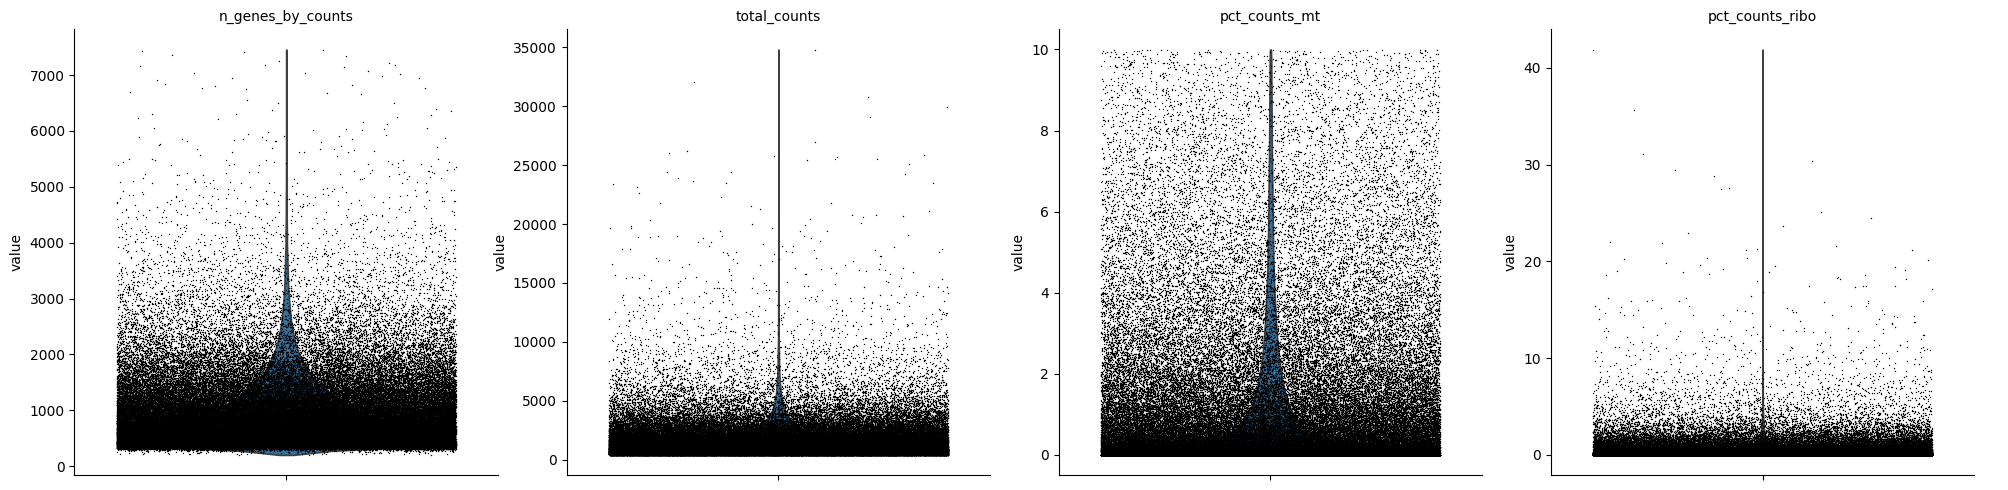

In [13]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], jitter=0.4, multi_panel=True)

**Calculate the 98th percentile** of the gene count distribution and **filters out cells exceeding this limit**. Cells with unusually **high gene counts can often be doublets or multiplets** (more than one cell captured in a single droplet or well), and removing them helps in maintaining the integrity of single-cell analyses.

In [14]:
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
adata = adata[adata.obs.n_genes_by_counts < upper_lim]

Cells are further filtered to remove those with **more than 20% of their total RNA counts coming from mitochondrial genes**. High mitochondrial content can indicate stressed or dying cells, as mitochondrial genes may be overrepresented when the cytoplasmic mRNA is lost.


In [15]:
adata = adata[adata.obs.pct_counts_mt < 20]

Finally, this line filters out **cells with more than 2% of their RNA counts coming from ribosomal genes**. High levels of ribosomal RNA might suggest an issue with RNA extraction and library preparation, as ribosomal RNA is typically depleted in the sample preparation phase of most scRNA-seq protocols.

In [16]:
adata = adata[adata.obs.pct_counts_ribo < 2]

In [17]:
adata.layers['counts'] = adata.X.copy()

adata

/var/folders/ks/61tstkzx4rj7v0my891xbvx40000gn/T/ipykernel_955/2549575511.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts'] = adata.X.copy()


AnnData object with n_obs × n_vars = 108953 × 21957
    obs: 'Sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    layers: 'counts'

In [18]:
adata.write_h5ad('./processed_datasets/processed_dataset.h5ad')

##### Normalization 

In [19]:
adata = sc.read_h5ad('./processed_datasets/processed_dataset.h5ad')

In [20]:
# Calculate the total counts for each cell. The .sum(axis=1) operation sums up all entries along the axis 1 (columns), resulting in a total count per row (cell).

adata.X.sum(axis=1)

matrix([[5500.],
        [5215.],
        [5099.],
        ...,
        [ 402.],
        [ 405.],
        [ 403.]], dtype=float32)

The following function normalizes the gene expression measurements in each cell so that every cell has the same total count of transcripts after normalization.  Each cell’s count vector is scaled so that the sum of counts becomes equal to 10,000.

In [21]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [22]:
adata.X.sum(axis=1)

matrix([[10000.   ],
        [10000.   ],
        [10000.   ],
        ...,
        [10000.001],
        [10000.   ],
        [10000.001]], dtype=float32)

This function applies a **log transformation** (log1p stands for log(x+1)) to the count data. This transformation is often used in RNA-seq data analysis to stabilize the variance across the range of count values

In [23]:
sc.pp.log1p(adata)

In [24]:
adata.X.sum(axis=1)

matrix([[3508.7788],
        [3700.7148],
        [3144.7805],
        ...,
        [1027.5013],
        [1032.8884],
        [1111.9678]], dtype=float32)

##### Identifying Highly Variable Genes

The following function **selects the top 2000 genes** with the **highest variance across the cells**. These genes are  used to **identify and flag the genes** that are the most variable across the single-cell dataset. Identifying these genes is crucial for highlighting features that might be critical for **distinguishing between different cell types or states** in single-cell analyses.

In [25]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)
adata.var

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
AL627309.1,False,False,158,0.001358,99.864161,158.0,158,False,0.009917,2.401317,-0.440478
AL627309.5,False,False,482,0.004187,99.585604,487.0,482,False,0.026899,2.310705,-0.901255
LINC01409,False,False,2875,0.026618,97.528243,3096.0,2875,False,0.169066,2.486031,-0.009699
LINC01128,False,False,2291,0.021339,98.030332,2482.0,2291,False,0.137704,2.497481,0.048525
LINC00115,False,False,295,0.002545,99.746376,296.0,295,False,0.016966,2.415998,-0.365824
...,...,...,...,...,...,...,...,...,...,...,...
SPRR3,False,False,109,0.001376,99.906288,160.0,109,False,0.007746,2.664463,0.897651
HOXC10,False,False,100,0.000911,99.914026,106.0,100,False,0.004877,2.145875,-1.739432
CCL7,False,False,163,0.001986,99.859862,231.0,163,False,0.007251,2.407840,-0.407311
TFF2,False,False,188,0.002725,99.838369,317.0,188,False,0.009317,2.422128,-0.334651


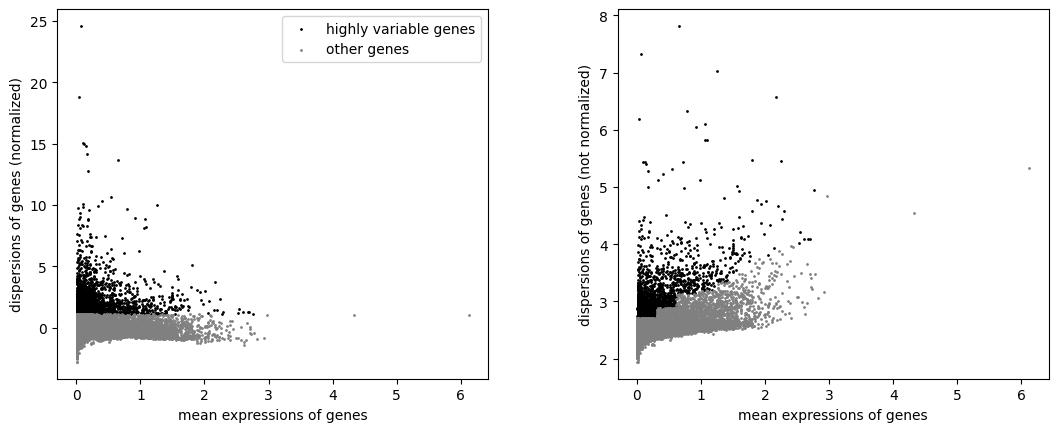

In [26]:
# Plotting the distribution and classification of genes as highly variable or not, providing a visual inspection of the variability criteria

sc.pl.highly_variable_genes(adata)

##### Filtering for Highly Variable Genes
Restricts the dataset to only include the highly variable genes

In [27]:
adata.var

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
AL627309.1,False,False,158,0.001358,99.864161,158.0,158,False,0.009917,2.401317,-0.440478
AL627309.5,False,False,482,0.004187,99.585604,487.0,482,False,0.026899,2.310705,-0.901255
LINC01409,False,False,2875,0.026618,97.528243,3096.0,2875,False,0.169066,2.486031,-0.009699
LINC01128,False,False,2291,0.021339,98.030332,2482.0,2291,False,0.137704,2.497481,0.048525
LINC00115,False,False,295,0.002545,99.746376,296.0,295,False,0.016966,2.415998,-0.365824
...,...,...,...,...,...,...,...,...,...,...,...
SPRR3,False,False,109,0.001376,99.906288,160.0,109,False,0.007746,2.664463,0.897651
HOXC10,False,False,100,0.000911,99.914026,106.0,100,False,0.004877,2.145875,-1.739432
CCL7,False,False,163,0.001986,99.859862,231.0,163,False,0.007251,2.407840,-0.407311
TFF2,False,False,188,0.002725,99.838369,317.0,188,False,0.009317,2.422128,-0.334651


In [28]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 108953 × 2000
    obs: 'Sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

##### Regression and Scaling

For **each gene**, the function constructs a **linear model** where the **gene expression** is the dependent variable and the **unwanted factors** (total_counts, pct_counts_mt, and pct_counts_ribo) are the **independent variables**. 

The goal is to quantify how much of the variance in gene expression can be explained by these factors

In [29]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

/usr/local/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


 Scaling the data to have **zero mean and unit variance**, with a clipping of values at 10 standard deviations to mitigate the impact of extreme outliers.

In [30]:
sc.pp.scale(adata, max_value=10)

In [31]:
adata.write_h5ad('./processed_datasets/normalized_dataset.h5ad')

##### Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a statistical technique used to **reduce the dimensionality** of a dataset while **retaining as much variability as possible**. This is achieved by transforming the original variables into a new set of variables, which are orthogonal (as each principal component is uncorrelated with the others) and are ordered so that the first few retain most of the variation present in all of the original variables.

In [32]:
adata = sc.read_h5ad('./processed_datasets/normalized_dataset.h5ad')

In [33]:
# Performs PCA on the dataset to reduce dimensionality

sc.tl.pca(adata, svd_solver='arpack')

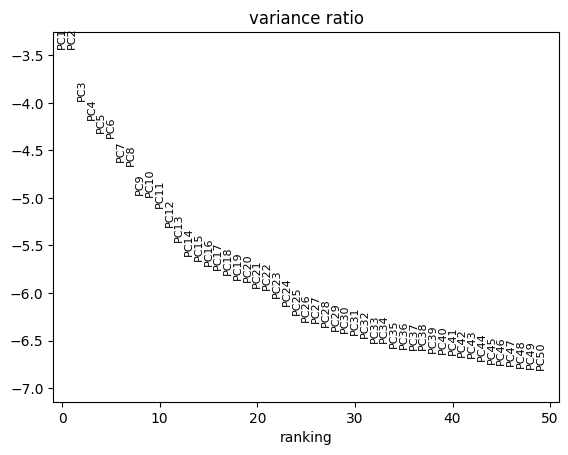

In [34]:
# Plots the explained variance ratio of the principal components

sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [35]:
# Constructs the k-nearest neighbors graph using the PCA-transformed data

sc.pp.neighbors(adata, n_pcs = 30)

In [36]:
# Applies Uniform Manifold Approximation and Projection (UMAP) to the data for further dimensionality reduction and visualization

sc.tl.umap(adata)

# This function applies the Leiden algorithm to detect clusters of cells within the data

sc.tl.leiden(adata, resolution = 0.5)

/var/folders/ks/61tstkzx4rj7v0my891xbvx40000gn/T/ipykernel_955/3611336531.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.5)


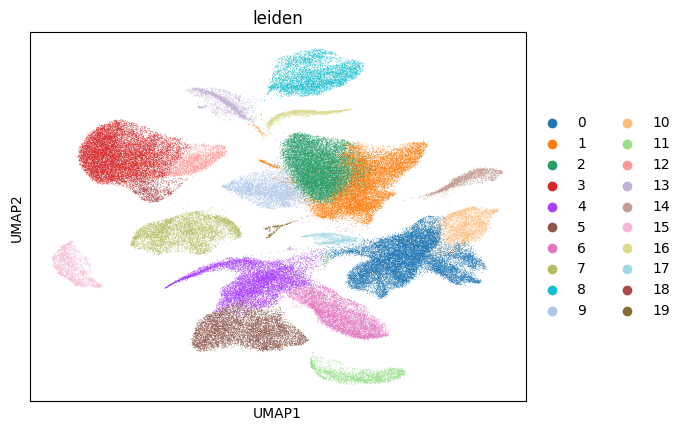

In [37]:
# Visualizes the cells in a two-dimensional space using UMAP (Uniform Manifold Approximation and Projection), colored by the Leiden clustering results

sc.pl.umap(adata, color=['leiden'])

#### Identify Differentially Expressed Genes (DEGs)

Differential expression (DE) analysis using Scanpy is an efficient way to identify **genes that are significantly differentially expressed** across different cell clusters.

In [39]:
# This function compares each group (e.g., cell cluster) against all others using a statistical test to determine if a gene's expression is significantly different between groups.

sc.tl.rank_genes_groups(adata, groupby='leiden')

/usr/local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: 

In [40]:
# Extracting Results

results = adata.uns['rank_genes_groups']
groups = results['names'].dtype.names
top_genes = pd.DataFrame({group: results['names'][group] for group in groups})
top_genes.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,LAMA2,CD163,CTSB,SKAP1,MACROD2,PDE4D,NCKAP5,LDB2,IFNG-AS1,PPARG,PRKG1,RP1,CD247,BANK1,PPFIBP1,PTPRN2,SLC24A3,PRKG1,SKAP1,ANK1
1,COL1A2,CTSB,PSAP,THEMIS,PDE4D,LRRK2,LMO7,EPAS1,TXNDC5,SLC11A1,ROBO2,DNAH12,AOAH,AFF3,SEMA3A,LINC01876,KIT,CALD1,MKI67,SLC25A37
2,COL6A3,RBPJ,KCNMA1,CAMK4,ROS1,ZNF385B,EMP2,ADGRL2,CEP128,MRC1,LSAMP,AGBL4,SKAP1,EBF1,KALRN,LINC00342,IL18R1,CACNA1C,ASPM,SLC4A1
3,PRKG1,MRC1,CTSD,BCL11B,LMO7,ERBB4,KHDRBS2,VWF,CREB3L2,LSAMP,SLIT2,CFAP299,CARD11,BLK,LDB2,ANKRD36C,SYTL3,EBF1,TOP2A,SPTA1
4,COL3A1,F13A1,FTL,CNOT6L,ERBB4,ROS1,LAMA3,GALNT18,TENT5C,STAC,CACNA1C,CDHR3,SAMD3,BACH2,PKHD1L1,RGS6,CPA3,INPP4B,SLFN12L,HBB


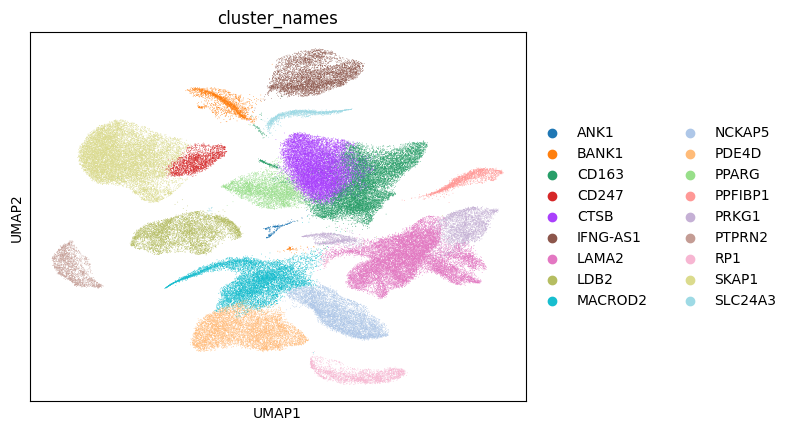

In [42]:
# Replace cluster numbers with names
adata.obs['cluster_names'] = adata.obs['leiden'].map(top_genes.iloc[0].to_dict())

# Visualize the UMAP with new cluster names
sc.pl.umap(adata, color=['cluster_names'])